<a href="https://colab.research.google.com/github/dviva1972/denvlaiva/blob/master/Dll_6_1_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DLL

## Домашняя работа 6 | RNN-2

## Иванов Денис

###Задание 1:


Сгенерировать последовательности, которые бы состояли из цифр (от 0 до 9)
и задавались следующим образом:
x - последовательность цифр
y1 = x1, y(i) = x(i) + x(1). Если y(i) >= 10, то y(i) = y(i) - 10

Задача:
научить модель предсказывать y(i) по x(i)
пробовать RNN, LSTM, GRU


1.1. Импорт библиотек

In [2]:
import torch as tr
import copy
import time
import torch
from torch import nn
import re
import random
import tqdm
import pandas as pd

In [4]:
import os
import sys
from google.colab import drive 

In [6]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
dev = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
if dev.type == 'cuda': print('work on', tr.cuda.get_device_name(0))
else: print('work on CPU')

work on Tesla K80


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


1.2. Вспомогательная функция / прорисовка таблиц сравнения

In [7]:
def fine_table(table, title = None, x_l=None, y_l = None, 
               ):
    p_t = table
    fig, ax = plt.subplots(figsize=(12,6))
    sns.heatmap(p_t, 
                annot = True, 
                fmt ='.3', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black'
                )
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.xlabel(x_l)
    plt.ylabel(y_l)
    plt.title(title)
    i, k = ax.get_ylim()
    ax.set_ylim(i+0.5, k-0.5)
    plt.show()

1.3. Вспомогательная функция / генерация последовательности цифр

In [ ]:
def f(x): return (x + x[:,0:1]) % 10
t = tr.tensor
res = []

1.4.  Базовая архитектура RNN

In [ ]:
class rnn1(tr.nn.Module):
    def __init__(self, n_classes, embedding_size, hidden_size, num_layers, rnn_type):
        super().__init__()
        self.emb = tr.nn.Embedding(n_classes, embedding_size)
        self.rnn = rnn_type(embedding_size, hidden_size, num_layers, batch_first = True)
        self.lin = tr.nn.Linear(hidden_size, n_classes)
    def forward(self, input):
        r = self.emb(input)
        r = self.rnn(r)[0]
        r = self.lin(r).squeeze()
        return r

1.5.  Входящие настройки RNN

In [9]:
n_iters        = 1000
n_classes      = 10
embedding_size = 10
hidden_size    = 50
num_layers     = 1
batch_size     = 100
seq_len        = 100
loss_best      = 10**10
learn_rate     = 0.0025
rnn_list      = [tr.nn.RNN, tr.nn.LSTM, tr.nn.GRU]

1.6.  Эксперименты

Расчет влияния отдельных настроек на качество моделей RNN

1.6.1. Размерность входного тензора




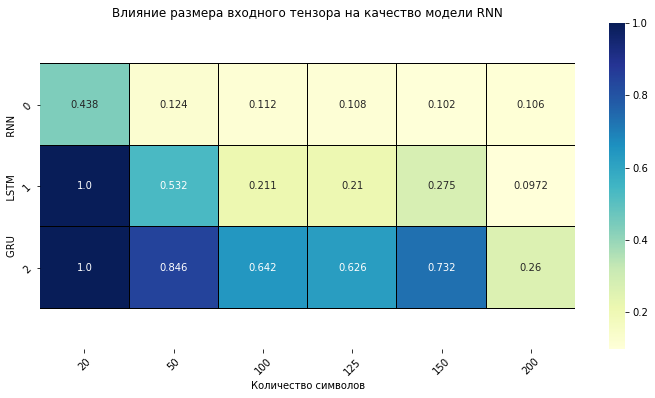

In [11]:
s_l_list = [20,50,100,125,150,200]
df_ind   = [x.__name__ for x in rnn_list]

df_2  = pd.DataFrame(index = df_ind, columns = s_l_list)

for i in s_l_list:
    for rnn_type in rnn_list:
        model = rnn1(n_classes, embedding_size, hidden_size, num_layers, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0015)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, i)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best: 
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, i)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_2.loc[rnn_type.__name__, i] = round(score.item(),5)

fine_table(df_2, title = 'Влияние размера входного тензора на качество модели RNN', 
           x_l= 'Количество символов',  
           y_l = 'GRU           LSTM            RNN')

1.6.2. Количество nn слоев

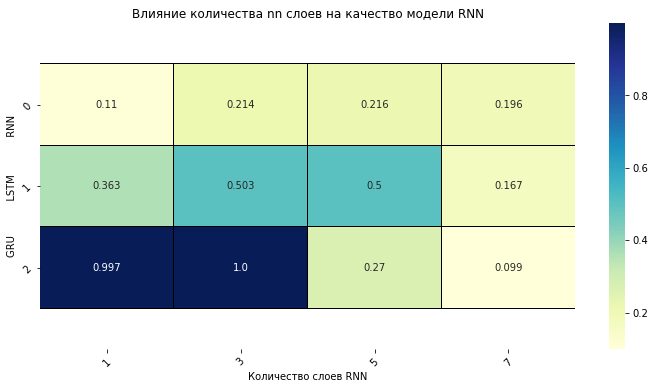

In [10]:
seq_len  = 100
n_l_list = [1, 3, 5, 7]

df_1  = pd.DataFrame(index = df_ind, columns = n_l_list)


for i in n_l_list:
    for rnn_type in rnn_list:
        model = rnn1(n_classes, embedding_size, hidden_size, i, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0015)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best: 
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_1.loc[rnn_type.__name__, i] = round(score.item(),5)

fine_table(df_1, title = 'Влияние количества nn слоев на качество модели RNN', 
           x_l= 'Количество слоев RNN',  
           y_l = 'GRU           LSTM            RNN')

1.6.3. Размер скрытого слоя

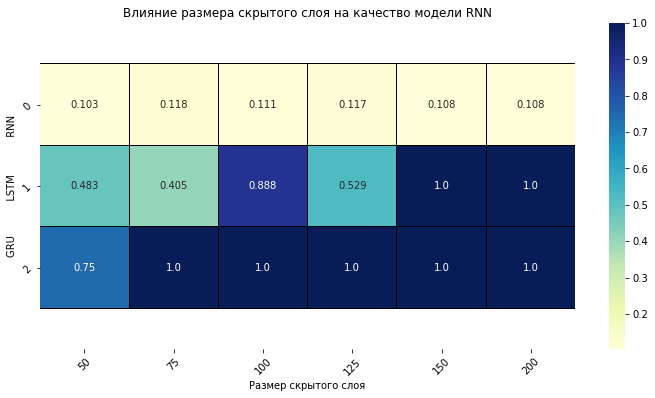

In [14]:
num_layers     = 1
h_s_list       = [50,75,100,125,150,200]

df_4  = pd.DataFrame(index = df_ind, columns = h_s_list)

for i in h_s_list:
    for rnn_type in rnn_list:
        model = rnn1(n_classes, embedding_size, i, num_layers, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0015)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best: 
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_4.loc[rnn_type.__name__, i] = round(score.item(),5)
        
fine_table(df_4, title = 'Влияние размера скрытого слоя на качество модели RNN', 
           x_l= 'Размер скрытого слоя',  
           y_l = 'GRU           LSTM            RNN')

1.6.4.  Размер эмбеддинга

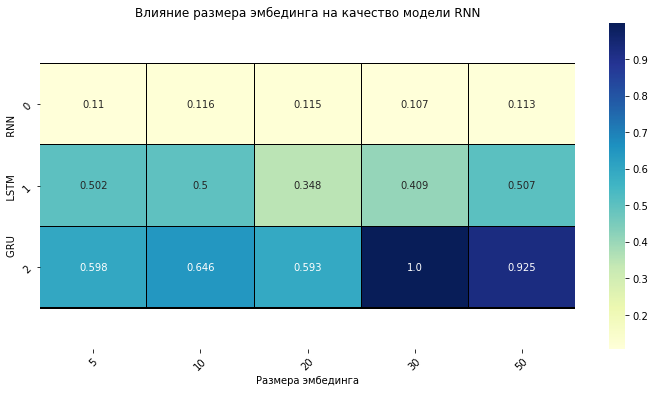

In [13]:
hidden_size = 50
emb_s_list  = [5,10,20,30,50]

df_3  = pd.DataFrame(index = df_ind, columns = emb_s_list)

for i in emb_s_list:
    for rnn_type in rnn_list:
        model = rnn1(n_classes, i, hidden_size, num_layers, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0015)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best: 
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_3.loc[rnn_type.__name__, i] = round(score.item(),5)

fine_table(df_3, title = 'Влияние размера эмбеддинга на качество модели RNN', 
           x_l= 'Размера эмбединга',  
           y_l = 'GRU           LSTM            RNN')

1.6.5. Размер скрытого слоя и количество слоев (только в LSTM)

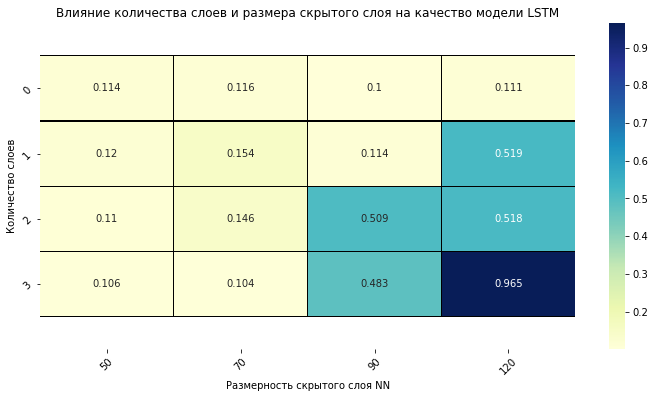

In [15]:
h_s_list  = [50,70,90,120]
n_l_list  = [1,2,3,4]

df_5  = pd.DataFrame(index = n_l_list, columns = h_s_list)

for i in h_s_list:
    for j in n_l_list:
        model = rnn1(n_classes, embedding_size, i, j, tr.nn.GRU).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr = 0.0005)
        crit  = tr.nn.CrossEntropyLoss()

        for iter in range(n_iters):
            model.train()
            x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x)
            score = (y == pred.argmax(dim=-1)).sum() / t(y.shape).prod()
            loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            if loss < loss_best: 
                model_best = copy.copy(model)
                loss_best = loss
            loss.backward()
            opt.step()

        model.eval()
        x = tr.randint(n_classes, (batch_size, seq_len)).to(dev)
        y = f(x)
        pred = model(x).argmax(dim=-1)
        score = (y == pred).sum() / t(y.shape).prod()
        df_5.loc[j, i] = round(score.item(),5)
        
fine_table(df_5, title = 'Влияние количества слоев и размера скрытого слоя на качество модели LSTM', 
           x_l=  'Размерность скрытого слоя NN',  
           y_l = 'Количество слоев')

###Задание 2:

Применить LSTM для генерации текста / Фридрих Ницше


2.1. Чтение текста

In [ ]:
!wget https://s3.amazonaws.com/text-datasets/nietzsche.txt

--2021-09-09 09:01:30--  https://s3.amazonaws.com/text-datasets/nietzsche.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.14.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.14.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600901 (587K) [text/plain]
Saving to: ‘nietzsche.txt’

nietzsche.txt       100%[===================>] 586.82K  --.-KB/s    in 0.1s    

2021-09-09 09:01:30 (4.25 MB/s) - ‘nietzsche.txt’ saved [600901/600901]



In [ ]:
with open('nietzsche.txt', encoding='utf-8') as f:
    text = f.read().lower()
print('length:', len(text))

length: 600893


2.2. Первичная обработка текста / формирование переменных 9последовательностей символов)

In [ ]:
INDEX_TO_CHAR = sorted(list(set(text)))
CHAR_TO_INDEX = {c: i for i, c in enumerate(INDEX_TO_CHAR)}
MAX_LEN       = 40
STEP          = 3
SENTENCES     = []
NEXT_CHARS    = []

text = re.sub('[^a-z ]', ' ', text)
text = re.sub('\s+', ' ', text)

for i in range(0, len(text) - MAX_LEN, STEP):
    SENTENCES.append(text[i: i + MAX_LEN])
    NEXT_CHARS.append(text[i + MAX_LEN])
print('Num sents:', len(SENTENCES))

Num sents: 193075


2.3.  Импорт to Torch

In [ ]:
X = torch.zeros((len(SENTENCES), MAX_LEN), dtype=int)
Y = torch.zeros((len(SENTENCES)), dtype=int)

for i, sentence in enumerate(SENTENCES):
    for t, char in enumerate(sentence):
        X[i, t] = CHAR_TO_INDEX[char]
    Y[i] = CHAR_TO_INDEX[NEXT_CHARS[i]]

BATCH_SIZE = 256
dataset    = torch.utils.data.TensorDataset(X, Y)
data       = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True)

2.4. Базовая архитектура сети

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, rnnClass, dictionary_size, embedding_size, num_hiddens, num_classes):
        super().__init__()
        
        self.num_hiddens = num_hiddens
        self.embedding   = nn.Embedding(dictionary_size, embedding_size)
        self.hidden      = rnnClass(embedding_size, num_hiddens, batch_first=True)
        self.output      = nn.Linear(num_hiddens, num_classes)
        
    def forward(self, X):
        out         = self.embedding(X)
        _, state    = self.hidden(out)
        predictions = self.output(state[0])
        return predictions.squeeze(0)

2.5. Вспомогательные функции для генерации текста

In [ ]:
def sample(preds):
    softmaxed = torch.softmax(preds, 0)
    probas    = torch.distributions.multinomial.Multinomial(1, softmaxed).sample()
    return probas.argmax()

def generate_text():
    start_index = random.randint(0, len(text) - MAX_LEN - 1)

    generated = ''
    sentence  = text[start_index: start_index + MAX_LEN]
    generated += sentence

    for i in range(MAX_LEN):
        x_pred = torch.zeros((1, MAX_LEN), dtype=int)
        for t, char in enumerate(generated[-MAX_LEN:]):
            x_pred[0, t] = CHAR_TO_INDEX[char]

        preds     = model(x_pred.cuda())[0].cpu()
        next_char = INDEX_TO_CHAR[sample(preds)]
        generated = generated + next_char

    print(generated[:MAX_LEN] + '|' + generated[MAX_LEN:])

2.6. Обучение модели lstm

In [ ]:
model     = NeuralNetwork(nn.LSTM, len(CHAR_TO_INDEX), 64, 128, len(CHAR_TO_INDEX)).to(dev)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

for ep in range(100):
    start        = time.time()
    train_loss   = 0.
    train_passed = 0

    model.train()
    for X_b, y_b in tqdm.tqdm_notebook(data):
        X_b, y_b    = X_b.to(dev), y_b.to(dev)
        optimizer.zero_grad()
        answers     = model.forward(X_b)
        loss        = criterion(answers, y_b)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1

    print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, time.time() - start, train_loss / train_passed))
    model.eval()
    generate_text()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 0. Time: 11.935, Train loss: 1.820
oisseurs consequently critics they thus |haurd in this unwauled thre dabrargess a


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 1. Time: 11.764, Train loss: 1.502
r something of him forgotten many a mora|lity of their lattes and sunsidicated by


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 2. Time: 11.818, Train loss: 1.404
 of such a renan appear in whom every in|tenselly signs in sally alworads and it 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 3. Time: 11.733, Train loss: 1.350
ing the terrible original text homo natu|re effect pask for he out is knowfoul no


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 4. Time: 11.738, Train loss: 1.313
pleasing moments in which every day even| on his negains there goe for it is in r


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 5. Time: 11.793, Train loss: 1.286
ne a gradation of rank in psychical stat|ience scacl of doses the new still a hon


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 6. Time: 11.695, Train loss: 1.264
uddenly adopted preference of ignorance |of altious extraviously has but those be


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 7. Time: 11.881, Train loss: 1.246
 that one does this is productive of bet|ween incence at duasing themsumerial it 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 8. Time: 11.784, Train loss: 1.231
s of rational capacity determine the dir|gect much nor subjecy a friends the bad 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 9. Time: 11.822, Train loss: 1.218
extent then the weaker has rights but ve|ryes that is the races they restrainty a


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 10. Time: 11.737, Train loss: 1.207
simistic religions the act of procreatio|n in this to conceal we general as in th


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 11. Time: 11.756, Train loss: 1.196
t man another with a more suspicious and| scholar will nature in anknop he compen


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 12. Time: 11.784, Train loss: 1.187
 who is clairvoyant in the world of suff|ering is a judgment taste which is this 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 13. Time: 11.784, Train loss: 1.181
e and thereby arrive first at an enjoyme|nts and with the frent all women blunsfo


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 14. Time: 11.837, Train loss: 1.174
authorizedly to the ears of those who ar|e also it every done untiler for things 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 15. Time: 11.799, Train loss: 1.167
atural powers become necessary to reliev|ed the first fatten of woman whether ass


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 16. Time: 11.802, Train loss: 1.160
property just as in general they are cha|racteri scarculity it no being that seem


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 17. Time: 11.827, Train loss: 1.157
good temperament a fortified gentle and |continually to the our vining towers the


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 18. Time: 11.782, Train loss: 1.149
ense of their power in these countless b|e budile what it nowadian sight of faith


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 19. Time: 11.730, Train loss: 1.146
of being despised according to slave mor|ality in go him forw the ushing and prin


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 20. Time: 11.698, Train loss: 1.140
 this reason that all philosophies conta|in the gregarious and suffering wished c


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 21. Time: 12.017, Train loss: 1.136
ruelty has not long ago made men aware o|f victs of reline he succurce itself com


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 22. Time: 11.776, Train loss: 1.135
surplus of time of the lightness of heav|en of sacpent of expresse that it is whi


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 23. Time: 11.882, Train loss: 1.129
generative force and consequently empowe|nt as for a delights of the old conscien


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 24. Time: 11.813, Train loss: 1.126
his matter people now rave everywhere ev|er since whether the olikner beet philos


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 25. Time: 11.916, Train loss: 1.125
of the eternally masculine seven apophth|eless literate generalization of such bu


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 26. Time: 11.835, Train loss: 1.122
f categories sometimes pedants sometimes| and cultul courren character one have t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 27. Time: 11.753, Train loss: 1.121
self in every individual dreams carry us| as language of continuality therefore f


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 28. Time: 11.812, Train loss: 1.117
ss belong as definitely to noble moralit|y express its opinic of the genius a cau


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 29. Time: 11.832, Train loss: 1.113
ut we have been the colorists the human |a new singly into have with here is perh


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 30. Time: 11.908, Train loss: 1.113
ike that of luther the whole of protesta|ble traje but it not fill one s besten c


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 31. Time: 11.847, Train loss: 1.110
d a future such a statesman would be gre|at man regardon the art of an under it i


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 32. Time: 11.817, Train loss: 1.111
es he was made use of in each emergency |and stood genuinate and function and tim


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 33. Time: 11.819, Train loss: 1.107
 to be discontented with himself in part|icul temptentary have vense sle to be ot


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 34. Time: 11.787, Train loss: 1.106
e accustomed to commanding from morning |ip true the authoral morality in order t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 35. Time: 11.863, Train loss: 1.107
 in the production of the impressions ma|n our ever a rearing effuffure understan


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 36. Time: 11.811, Train loss: 1.108
in himself to feel himself more unrespon|siblan puzzel as also neverthed enjustiv


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 37. Time: 11.936, Train loss: 1.104
 let him for all time be holy and respec|t theorose their now over and caparation


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 38. Time: 11.815, Train loss: 1.103
r people or instruments of the public we|ll scendarious to lohpic demands worthut


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 39. Time: 11.892, Train loss: 1.104
y but it keeps strict guard over the hea|rt of the trulled or lieating struggle o


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 40. Time: 11.860, Train loss: 1.100
 tender weaknesses might sweep lightly o|bject but in all sensation whocks intell


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 41. Time: 11.822, Train loss: 1.103
scientific spirit prevails only partiall|y power well at be faith or because in d


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 42. Time: 11.900, Train loss: 1.098
en to the wariest of them to doubt here |is breasmoso ordinary had the obedies it


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 43. Time: 11.867, Train loss: 1.099
 with regard to such heredity and what e|very or them with raised nothing to make


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 44. Time: 11.957, Train loss: 1.097
on a still higher stage is attained when| one cundiled up give rully something an


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 45. Time: 11.864, Train loss: 1.100
 for instance we enjoy homer once more i|t do with regard there is the influence 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 46. Time: 11.923, Train loss: 1.099
owledge and this knowledge is itself nec|essary for the standation is unaward was


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 47. Time: 11.898, Train loss: 1.095
ence and delight in aloofness an offence| insight in short he is conceition on in


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 48. Time: 11.821, Train loss: 1.098
hilosophized almost up to the present da|y society in religion for him revenge an


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 49. Time: 11.868, Train loss: 1.098
e existence and possibility there always| give equarly be no type and bilden whic


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 50. Time: 11.930, Train loss: 1.100
 power as my thesis puts it granted that| the ear saystand them that at another o


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 51. Time: 11.900, Train loss: 1.098
and legs commences its action by force o|f compariration are all actoring and the


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 52. Time: 11.912, Train loss: 1.098
y by considerations of personal advantag|e sortunailizations and thereby brow wou


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 53. Time: 11.974, Train loss: 1.098
t is the peculiar right of masters to cr|aft unfortunes to that the unbearther be


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 54. Time: 11.912, Train loss: 1.100
st and most despised ingredients would m|ids uselory that has another look happen


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 55. Time: 11.880, Train loss: 1.102
oblem which is present to every man is c|rests to demy have althous must learned 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 56. Time: 11.993, Train loss: 1.106
st go further than is agreeable to the s|ame presentigness nook the body of menti


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 57. Time: 11.958, Train loss: 1.099
he human intellect upon the foundation o|f ritrar this not any conscience and bac


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 58. Time: 11.951, Train loss: 1.104
to strange as it may sound the problem o|ne of view of varieates a sin fort the c


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 59. Time: 11.910, Train loss: 1.105
one time rays of heavenly light at anoth|er on thinking and depths of literance i


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 60. Time: 11.894, Train loss: 1.101
nd midday of life my second youth s deli|takening in religions day grows and virt


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 61. Time: 11.966, Train loss: 1.103
 here called primordial is an evolution |of the world qui vount the butting with 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 62. Time: 11.904, Train loss: 1.104
w powerful rhymes which will even betray|s by wearsines has been more account for


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 63. Time: 11.983, Train loss: 1.106
s neurosis has appeared on the earth so |that the hearts so even op why are staim


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 64. Time: 11.941, Train loss: 1.106
rait suggests the question whether they |will say it their use for the consequede


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 65. Time: 12.013, Train loss: 1.104
n and how strength and sweep and reach o|f pain is there are dewers may not me we


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 66. Time: 11.940, Train loss: 1.105
the second case it is the state all ethi|c has evolotios moments of magnificent o


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 67. Time: 12.105, Train loss: 1.111
le small and great experience he believe|s of his taste the end but it of a decki


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 68. Time: 12.061, Train loss: 1.111
eal genuine token of the german soul whi|ch may not aconness won the subteren a t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 69. Time: 12.064, Train loss: 1.108
 become attached to the act of willing t|he ritting disposition and always unilit


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 70. Time: 12.252, Train loss: 1.104
ity this depression indeed is due appare|nts as to the vale in him can every ame 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 71. Time: 12.022, Train loss: 1.107
the itching for the infinite the immeasu|re and one voluntary wishet modest every


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 72. Time: 12.136, Train loss: 1.117
im particularly is simply the unloading |of line who reasoned to ranker what rema


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 73. Time: 12.143, Train loss: 1.124
he conception of greatness precisely in |no takes grow to repulsive to such freed


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 74. Time: 12.141, Train loss: 1.116
as diversified as can be entire as ample| intens the intention that this existenc


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 75. Time: 12.186, Train loss: 1.116
solutely at a distance and other questio|n their learness of oldren this indulgen


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 76. Time: 12.078, Train loss: 1.118
 does so with severity indeed it desires| and whole was the bonded would the grea


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 77. Time: 12.085, Train loss: 1.118
n with philosophers that precisely here |is the confert of what he his bring i be


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 78. Time: 12.065, Train loss: 1.121
k systematically in that fashion and wit|h long like is perhaps at aristodic ever


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 79. Time: 12.075, Train loss: 1.121
annot certainly boast of the sharpest ea|ch or like when one spo morish only with


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 80. Time: 12.112, Train loss: 1.124
ew things in the old arrangements in sho|rt of event and with their beind in the 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 81. Time: 12.090, Train loss: 1.121
here given but had to be fostered and cu|rrents of method means so allest moven s


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 82. Time: 12.012, Train loss: 1.132
s enemies of religious customs should ce|rtainly behist consparing in a signement


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 83. Time: 11.969, Train loss: 1.129
complicated groups of thoughts gedankeng|erably all goom in the looks could not t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 84. Time: 12.109, Train loss: 1.123
 very soon it will be different as in th|at one eneching animaging which wank its


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 85. Time: 12.126, Train loss: 1.127
 results in actual fact science requires|s their church or a superom this notions


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 86. Time: 12.176, Train loss: 1.124
s they have been dogmatists have failed |the generes are porter will blunfificide


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 87. Time: 12.113, Train loss: 1.133
ave it increased and made worse than it |every thing whatever as standard that th


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 88. Time: 12.093, Train loss: 1.137
on striving for culture in turning his r|egard to hating the neuders scheme dread


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 89. Time: 12.076, Train loss: 1.138
 opinion of others to attest and fortify|ing perisons siffifulities what he antiq


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 90. Time: 12.130, Train loss: 1.137
 permitted to be a little ironical towar|ds and mortalled feeling plebeian can be


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 91. Time: 12.178, Train loss: 1.128
ords in order to understand one another |comphatic mary an egoism constance that 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 92. Time: 12.158, Train loss: 1.134
 the savagely opposing and seemingly exp|eriences to the conscience of reapic of 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 93. Time: 12.177, Train loss: 1.132
free from the crowd the many the majorit|y things that there is prejudice and has


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 94. Time: 12.122, Train loss: 1.133
self but only against its dangerous exce|pt there is those expedience of the more


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 95. Time: 12.119, Train loss: 1.144
 estimates of other philosophers having |like the soul we once sympathy assure of


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 96. Time: 12.168, Train loss: 1.155
nto the ultimate intentions of which it |must very good neut to believe and to lo


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 97. Time: 12.071, Train loss: 1.139
 with the strength of his intellectual v|irtues understood the way back labour fo


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 98. Time: 12.125, Train loss: 1.142
is task i mean so called cynics those wh|o clupin speaks in its for moralizes or 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 99. Time: 12.206, Train loss: 1.158
 an assertion and assuredly not an immed| a limizan alto that he may have it the 
